# Neural Network 


In [49]:
# Package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
import warnings
warnings.filterwarnings('ignore')

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

## 生成数据


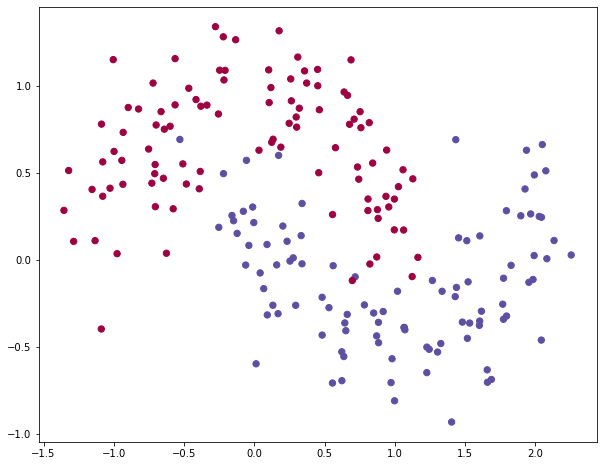

In [50]:
# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

## 逻辑回归分类器


In [51]:
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X, y)

LogisticRegressionCV()

In [52]:
# Helper function to plot a decision boundary.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

Text(0.5, 1.0, 'Logistic Regression')

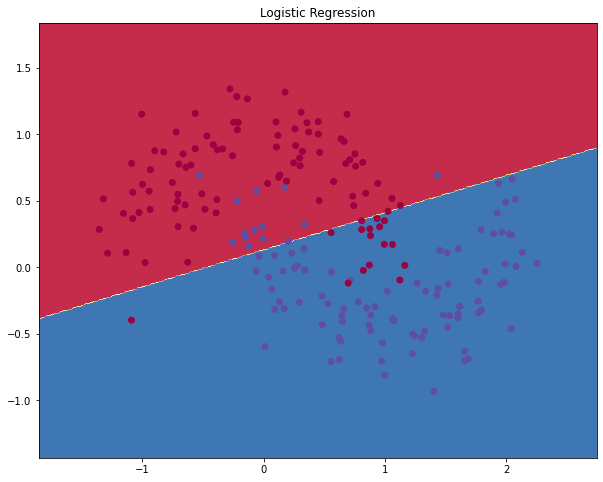

In [53]:
# Plot the decision boundary
plot_decision_boundary(lambda x: clf.predict(x))
plt.title("Logistic Regression")

## 训练神经网络

我们希望构建一个三层神经网络，包含一个输入层，一个隐藏层和一个输出层。其中输入层的节点数由输入数据的维数决定，输出层中的节点数量由类别数量决定，隐藏层的节点数目可以根据实际情况进行自定义。

<img src='./nn-3-layer-network.png' style='width: 50%'/>

在隐藏层中放置的节点越多，网络能够拟合越复杂的函数。但是更高的维度是有代价的：需要更多的计算来进行预测和学习网络参数，也意味着网络更容易过度拟合数据。


此外，还需要为隐藏层选择一个激活函数，负责将当前层的输入转换为输出。非线性激活函数允许我们拟合非线性假设。激活函数的常用选择有[tanh](https://reference.wolfram.com/language/ref/Tanh.html)、[sigmoid函数](https://en.wikipedia.org/wiki/Sigmoid＿function)或[ReLUs](https://en.wikipedia.org/wiki/Rectifier＿(neural＿networks)。这些函数的一个很好的性质是它们的导数可以用原始函数值来计算。例如，$\tanh x$的导数为$1-\tanh^2 x$。这种特性可以允许我们只计算$\tanh x$一次，并在以后重新使用它的值来获得导数。

在输出层，由于希望网络最终输出概率，输出层的激活函数将是[softmax](https://en.wikipedia.org/wiki/Softmax_function)，负责将原始分数转换为概率。

### 前向传播输出预测结果

zi是第i层的输入，ai是该层应用激活函数后的输出i，Wi,bi是需要我们通过训练数据来获取的神经网络参数，可以把它们当作在网络的层与层之间用于转化数据的矩阵。

$$
\begin{aligned}
z_1 & = xW_1 + b_1 \\
a_1 & = \tanh(z_1) \\
z_2 & = a_1W_2 + b_2 \\
a_2 & = \hat{y} = \mathrm{softmax}(z_2)
\end{aligned}
$$

### 参数学习

选择明确的交叉熵损失（cross-entropy loss）来衡量神经网络预测的错误率。如果有N个训练示例，C个类别，那么预测值相对于真实的有标签数据的损失则可以通过如下方法来计算获得:

$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}
\end{aligned}
$$



使用反向传播算法：首先计算各参数对应损失函数的梯度，并用梯度下降法对参数进行更新。

$$
\begin{aligned}
& \delta_3 = \hat{y} - y \\
& \delta_2 = (1 - \tanh^2z_1) \circ \delta_3W_2^T \\
& \frac{\partial{L}}{\partial{W_2}} = a_1^T \delta_3  \\
& \frac{\partial{L}}{\partial{b_2}} = \delta_3\\
& \frac{\partial{L}}{\partial{W_1}} = x^T \delta_2\\
& \frac{\partial{L}}{\partial{b_1}} = \delta_2 \\
\end{aligned}
$$

### 代码实现

In [54]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality

# Gradient descent parameters (I picked these by hand)
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength

计算损失

In [55]:
# evaluate the total loss on the dataset
def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

输出预测结果

In [56]:
# predict an output (0 or 1)
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

训练神经网络，在这个过程中使用之前找到的后向传播导数来进行批量梯度下降运算。

In [57]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(nn_hdim, num_passes=10000, print_loss=False):
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = {}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # Backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
          print("Loss after iteration %i: %f" %(i, calculate_loss(model)))
    
    return model

### 隐藏层规模为3的神经网络



Loss after iteration 0: 0.432387
Loss after iteration 1000: 0.068947
Loss after iteration 2000: 0.068924
Loss after iteration 3000: 0.071218
Loss after iteration 4000: 0.071253
Loss after iteration 5000: 0.071278
Loss after iteration 6000: 0.071293
Loss after iteration 7000: 0.071303
Loss after iteration 8000: 0.071308
Loss after iteration 9000: 0.071312


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

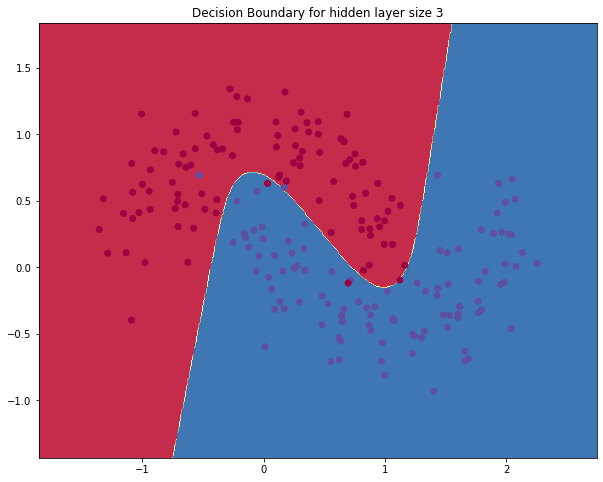

In [58]:
# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

## 改变隐藏层规模



Loss of hidden size 1: 0.328382
Loss of hidden size 2: 0.347410
Loss of hidden size 3: 0.070758
Loss of hidden size 4: 0.072374


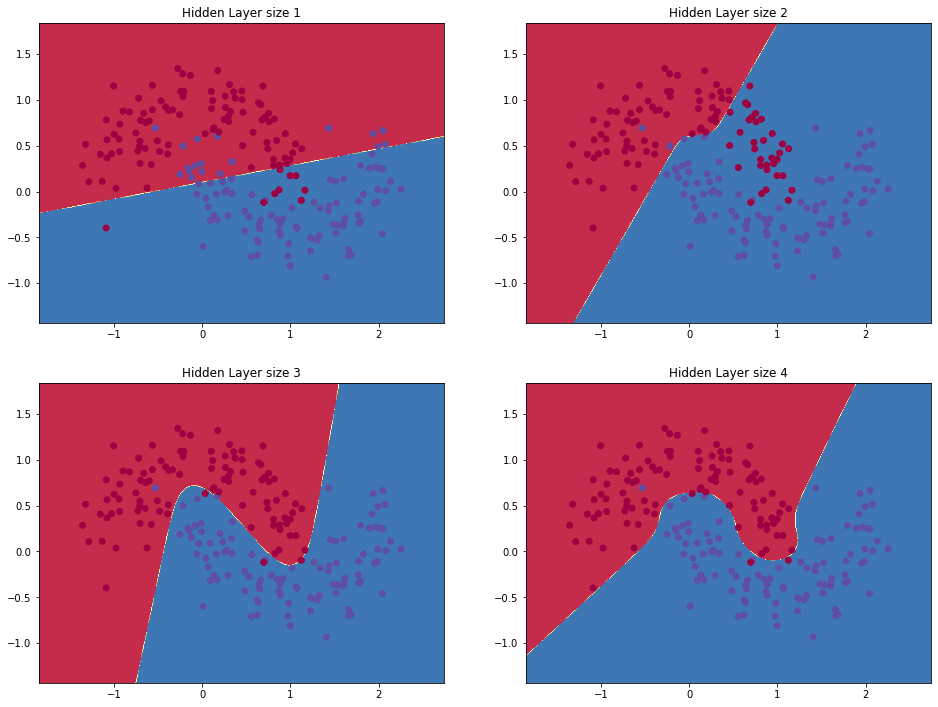

In [59]:
plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [1, 2, 3, 4]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % nn_hdim)
    model = build_model(nn_hdim)
    print("Loss of hidden size %i: %f" %(hidden_layer_dimensions[i], calculate_loss(model)))
    plot_decision_boundary(lambda x: predict(model, x))
plt.show()

# 使用sklearn中的MLPClassifier函数

Text(0.5, 1.0, 'MLPClassifier')

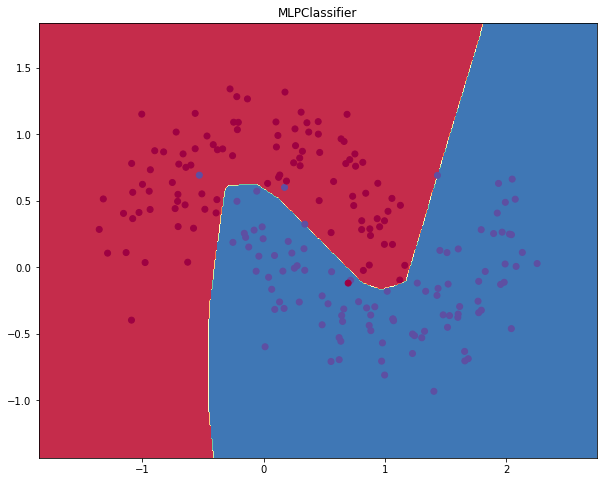

In [60]:
from sklearn.neural_network import MLPClassifier
mlp =MLPClassifier(hidden_layer_sizes=(50,3), activation='relu', solver='adam', max_iter=200000)
mlp.fit(X, y)
plot_decision_boundary(lambda x: mlp.predict(x))
plt.title("MLPClassifier")

MLPClassifier参数: https://blog.csdn.net/weixin_38278334/article/details/83023958